In [1]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
!pip install "gymnasium[atari, accept-rom-license]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 20.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.3 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446659 sha256=42f44e5f8e0364a5345a1cc7def246f5dacc3e2de824fbc4b8b001f7777fab6d
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [1]:
import random
import gymnasium as gym
#import math
import numpy as np
from collections import deque
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

In [8]:
EPOCHS = 500
THRESHOLD = 10


In [3]:
class DQN():
    def __init__(self, env_string,batch_size=64, IM_SIZE = 84, m = 4):
        self.memory = deque(maxlen=5000)
        self.env = gym.make(env_string, render_mode = "rgb_array_list")
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.gamma = 1.0
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.IM_SIZE = IM_SIZE
        self.m = m


        alpha=0.01
        alpha_decay=0.01
        #if MONITOR: self.env = gym.wrappers.Monitor(self.env, '../data/'+env_string, force=True)

        # Init model
        self.model = Sequential()
        self.model.add( Conv2D(32, 8, (4,4), activation='relu',padding='valid', input_shape=(IM_SIZE, IM_SIZE, m)))
        #self.model.add(MaxPooling2D())
        self.model.add( Conv2D(64, 4, (2,2), activation='relu',padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add( Conv2D(64, 3, (1,1), activation='relu',padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add(Flatten())
        self.model.add(Dense(256, activation='elu'))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=alpha))
        self.model_target = keras.models.clone_model(self.model)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, epsilon):
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state, verbose=0))

    def preprocess_state(self, img):
        if img.ndim != 3 or img.shape[2] != 3:
          raise ValueError("Input image must be height x width x 3 dimensions")
        img_temp = img[31:195]  # Choose the important area of the image
        img_temp = tf.image.rgb_to_grayscale(img_temp)
        img_temp = tf.image.resize(img_temp, [self.IM_SIZE, self.IM_SIZE],
                                   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        img_temp = tf.cast(img_temp, tf.float32)
        return img_temp[:,:,0]

    def combine_images(self, img1, img2):
        if len(img1.shape) == 3 and img1.shape[0] == self.m:
            im = np.append(img1[1:,:, :],np.expand_dims(img2,0), axis=2)
            return tf.expand_dims(im, 0)
        else:
            im = np.stack([img1]*self.m, axis = 2)
            return tf.expand_dims(im, 0)
        #return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model_target.predict(state, verbose=0)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state, verbose=0)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])

        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        print(f"test, lengh {len(x_batch)}")
        #epsilon = max(epsilon_min, epsilon_decay*epsilon) # decrease epsilon


    def train(self):
        scores = deque(maxlen=100)
        avg_scores = []


        for e in range(EPOCHS):
            state, info = self.env.reset()
            state = self.preprocess_state(state)
            state = self.combine_images(state, state)
            done = False
            i = 0
            while not done:
                action = self.choose_action(state,self.epsilon)
                next_state, reward, truncated, terminated, _ = self.env.step(action)
                done = terminated or truncated
                next_state = self.preprocess_state(next_state)
                next_state = self.combine_images(next_state, state)
                #print(next_state.shape)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon) # decrease epsilon
                i += reward

            scores.append(i)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score)
            if mean_score >= THRESHOLD:
                print('Solved after {} trials ✔'.format(e))
                return avg_scores
            if e % 10 == 0:
                print('[Episode {}] - Average Score: {}.'.format(e, mean_score))
                self.model_target.set_weights(self.model.get_weights())

            self.replay(self.batch_size)

        print('Did not solve after {} episodes 😞'.format(e))
        return avg_scores


In [9]:
env_string = 'BreakoutDeterministic-v4'
agent = DQN(env_string)


In [10]:
agent.model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 2, 2, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,652 (373.64 KB)

 Trainable params: 95,652 (373.64 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
agent.model_target.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 2, 2, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,652 (373.64 KB)

 Trainable params: 95,652 (373.64 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
scores = agent.train()

[Episode 0] - Average Score: 0.0.
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
[Episode 10] - Average Score: 0.45454545454545453.
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
[Episode 20] - Average Score: 0.47619047619047616.
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
[Episode 30] - Average Score: 0.41935483870967744.
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
[Episode 40] - Average Score: 0.4146341463414634.
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
test, lengh 64
[Episode 50] 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


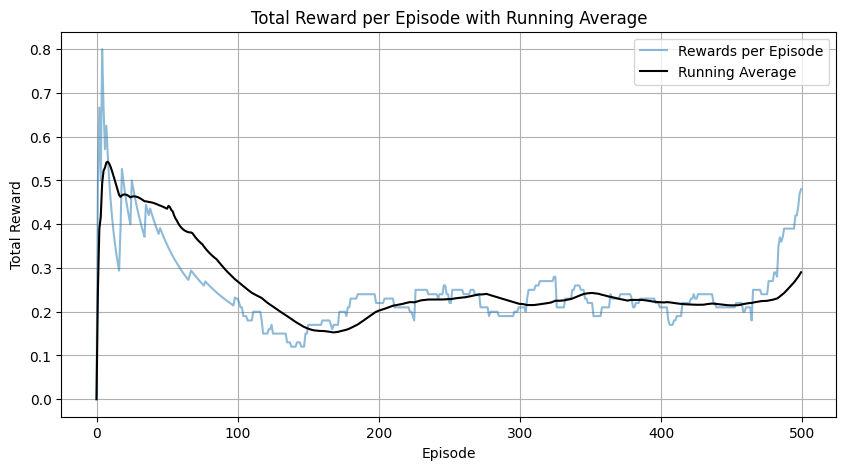

In [14]:
import matplotlib.pyplot as plt
window_size = 50  # Example window size for averaging
smoothed_rewards = [np.mean(scores[i-window_size:i+1]) if i >= window_size else np.mean(scores[:i+1]) for i in range(len(scores))]

plt.figure(figsize=(10, 5))
plt.plot(scores, label='Rewards per Episode', alpha=0.5)  # Original rewards, more transparent
plt.plot(smoothed_rewards, label='Running Average', color='black')  # Smoothed rewards
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode with Running Average')
plt.legend()
plt.grid(True)
plt.show()